---

# Simplified access to Veluwe ecological data through OGC Web Services

**Author:** Hudson Passos  
**Internship host:** Netherlands Institute of Ecology (NIOO-KNAW)  
**Host supervisor:** Stefan Vriend (NIOO-KNAW)  
**WUR supervisor:** Liesbeth Bakker (WUR, NIOO-KNAW)  
**Repository:** [research-project-internship-nioo](https://github.com/hudsonpassos/research-project-internship-nioo)  
**Date:** July 18, 2025  
**Python version:** 3.11.9  
**License:** MIT  
**Description:**  
This notebook is part of a research internship project. It focuses on the automated selection, filtering, 
and preprocessing of open ecological geospatial datasets for the Veluwe region using OGC Web Services (WCS and WFS).


---

# Data analysis

**Packages**

In [58]:
import pandas as pd
import geopandas as gpd
import time
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from owslib.csw import CatalogueServiceWeb
from owslib.ows import ServiceIdentification
import requests
from lxml import etree
import pandas as pd
import re
from collections import Counter

**Setting pathways**

In [2]:
root = "C:/Users/hudso/OneDrive/Documents/02. WUR/11. INTERNSHIP"
outlines_path = os.path.join(root, "02 data/outlines")
output_path = os.path.join(root, "05 python_project/output")

**Loading**

In [3]:
# Loading
df = pd.read_csv("checkpoint01_ngr_all_metadata.csv")

In [4]:
df_wcs = df[df['ogc_web_services'].str.contains(r'\bWCS\b', na=False)]
df_wfs = df[df['ogc_web_services'].str.contains(r'\bWFS\b', na=False)]

## 1. Metadata overview

In [5]:
df['resource_type'].value_counts()

resource_type
dataset        7626
service         938
GIS dataset      66
series           14
Name: count, dtype: int64

In [6]:
df['md_standard'].value_counts()

md_standard
ISO 19115    8718
ISO 19110     638
Name: count, dtype: int64

In [7]:
df['ogc_web_services'].value_counts()

ogc_web_services
WMS; WFS          3577
WMS; WCS           919
WMS                812
WFS; WMS           559
WFS                343
WMTS; WMS           41
WMS; WMTS           33
WMTS                21
SOS                  9
WCS                  5
WMS; WMTS; WCS       4
CSW                  3
WMS; WFS; WMTS       1
Name: count, dtype: int64

In [8]:
import pandas as pd

# Your original Index
ogc_services = df['ogc_web_services'].value_counts().index

# Split each entry by ';' and flatten the result
split_services = ogc_services.to_series().str.split('; ').explode().reset_index(drop=True)

# Get unique values if needed
unique_services = split_services.unique()

# Count rows where 'WCS' appears in the 'ogc_web_services' column
total_with_wcs = df['ogc_web_services'].str.contains(r'\bWFS\b', na=False).sum()


In [9]:
import pandas as pd

# Initialize list to hold results
results = []

# Loop through each unique service
for service in unique_services:
    total_ = df['ogc_web_services'].str.contains(fr'\b{service}\b', na=False).sum()
    results.append({'service': service, 'count': total_})

# Create DataFrame from the results
service_counts = pd.DataFrame(results)

# Optional: sort by count descending
service_counts = service_counts.sort_values('count', ascending=False).reset_index(drop=True)

print(service_counts)


  service  count
0     WMS   5946
1     WFS   4480
2     WCS    928
3    WMTS    100
4     SOS      9
5     CSW      3


In [10]:
df['language'].value_counts()

language
dut    8271
eng     320
Name: count, dtype: int64

In [11]:
valid_counts = df.notna().sum()
invalid_counts = df.isna().sum()

In [12]:
summary = pd.DataFrame({
    'valid': valid_counts,
    'not_valid': invalid_counts
})

In [13]:
summary

,valid,not_valid
identifier,9356,0
resource_type,8644,712
md_standard,9356,0
ogc_web_services,6327,3029
md_date,8712,644
language,8591,765
crs_epsg_codes,6373,2983
title,8645,711
keywords,7781,1575
abstract,8641,715


In [14]:
df.columns

Index(['identifier', 'resource_type', 'md_standard', 'ogc_web_services',
       'md_date', 'language', 'crs_epsg_codes', 'title', 'keywords',
       'abstract', 'md_contact_name', 'md_contact_email', 'landing_page',
       'data_creators', 'data_publishers', 'data_pointcontact', 'bounding_box',
       'license', 'access_rights', 'wcs_getcapabilities_url',
       'wfs_getcapabilities_url'],
      dtype='object')

In [15]:
new_column_names = ['Unique Identifier', 'Resource type', 'Metadata standard', 'OGC Web Services',
       'Metadata date', 'Metadata language', 'Spatial reference system', 'Title', 'Keywords',
       'Description', 'Responsible party', 'Eletronic email address', 'Landing page', 'Data creator',
       'Data publisher', 'Data contact point', 'Spatial coverage', 'License',
       'Access rights', 'WCS GetCapabilities URL', 'WFS GetCapabilities URL']

In [16]:
df_2 = df.copy()
df_2.columns = new_column_names

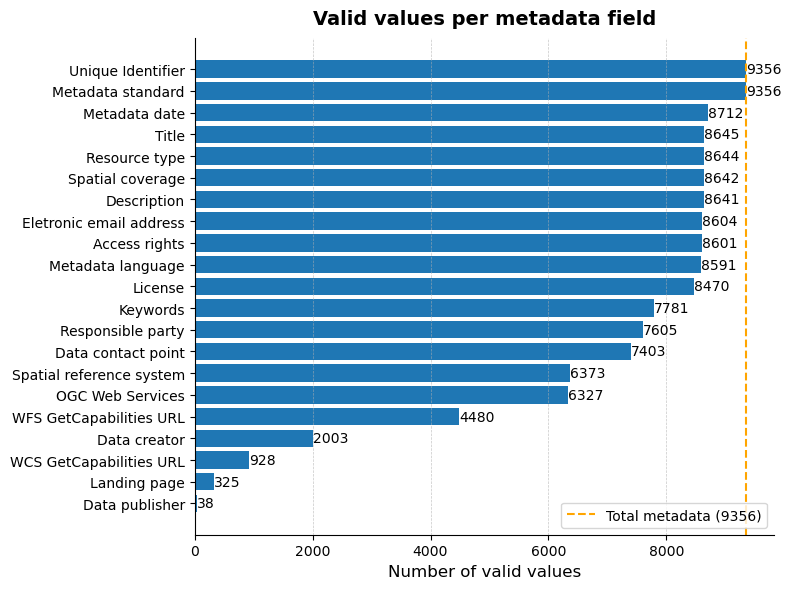

In [18]:
# Count and sort valid (non-null) values
valid_counts = df_2.notna().sum().sort_values()

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(valid_counts.index, valid_counts.values)

# Aesthetic improvements
ax.set_xlabel('Number of valid values', fontsize=12)
ax.set_title('Valid values per metadata field', fontsize=14, pad=10, fontweight='bold')

# Add grid and clean up plot
ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add vertical line at 9356
ax.axvline(x=9356, color='orange', linestyle='--', linewidth=1.5, label='Total metadata (9356)')
ax.legend(loc='lower right', fontsize=10)

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
            f'{int(width)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


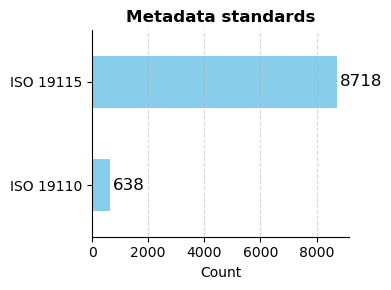

In [19]:
# Example value_counts from a column
vc = df['md_standard'].value_counts().sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(4, 3))  # small figure
vc.plot(kind='barh', ax=ax, color='skyblue')

# Aesthetics
ax.set_title('Metadata standards', fontsize=12, fontweight='bold')
ax.set_xlabel('Count', fontsize=10)
ax.set_ylabel('', fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, v in enumerate(vc.values):
    ax.text(v + 100, i, str(v), va='center', fontsize=12)

plt.tight_layout()
plt.show()

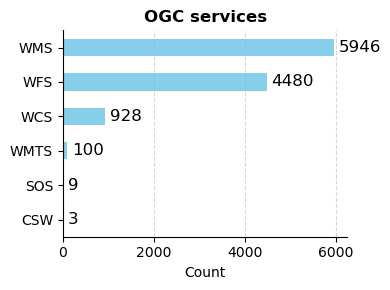

In [20]:
# Example value_counts from a column
service_counts.index = service_counts['service']
vc = service_counts['count'].sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(4, 3))  # small figure
vc.plot(kind='barh', ax=ax, color='skyblue')

# Aesthetics
ax.set_title('OGC services', fontsize=12, fontweight='bold')
ax.set_xlabel('Count', fontsize=10)
ax.set_ylabel('', fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, v in enumerate(vc.values):
    ax.text(v + 100, i, str(v), va='center', fontsize=12)

plt.tight_layout()
plt.show()

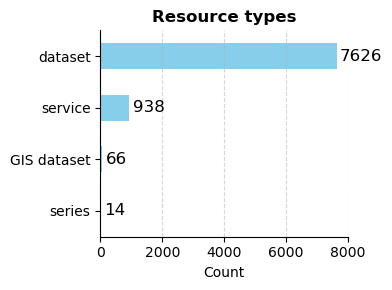

In [21]:
# Example value_counts from a column
vc = df['resource_type'].value_counts().sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(4, 3))  # small figure
vc.plot(kind='barh', ax=ax, color='skyblue')

# Aesthetics
ax.set_title('Resource types', fontsize=12, fontweight='bold')
ax.set_xlabel('Count', fontsize=10)
ax.set_ylabel('', fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, v in enumerate(vc.values):
    ax.text(v + 100, i, str(v), va='center', fontsize=12)

plt.tight_layout()
plt.show()

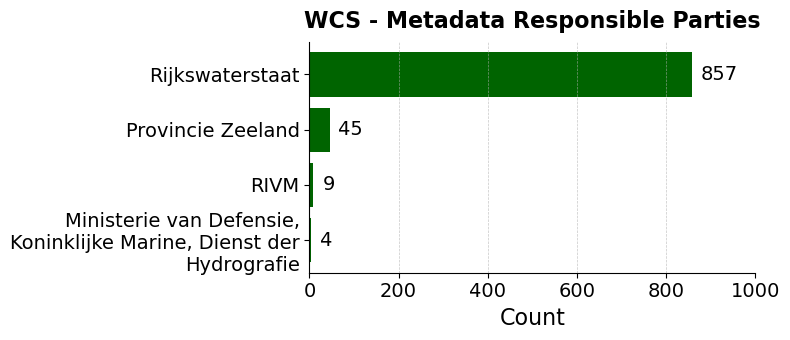

In [23]:
import textwrap

valid_counts = df_wcs['md_contact_name'].value_counts().sort_values(ascending=False)

# Wrap long labels
wrapped_labels = [
    '\n'.join(textwrap.wrap(label, width=30))  # adjust width as needed
    for label in valid_counts.index
]

# Plotting
fig, ax = plt.subplots(figsize=(8, 3.5))
bars = ax.barh(wrapped_labels, valid_counts.values, color='darkgreen')

# Invert y-axis to show highest counts on top
ax.invert_yaxis()

ax.set_xlim(0, 1000)

# Aesthetic improvements
ax.set_xlabel('Count', fontsize=16)
ax.set_title('WCS - Metadata Responsible Parties', fontsize=16, pad=10, fontweight='bold')

# Increase tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Add grid and clean up plot
ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 20, bar.get_y() + bar.get_height() / 2,
            f'{int(width)}', va='center', fontsize=14)

plt.tight_layout()
plt.show()


C:\Users\hudso\AppData\Local\Temp\ipykernel_14428\119860506.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=14)


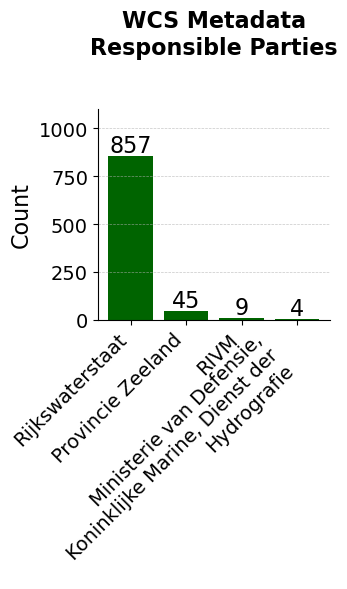

In [24]:
import textwrap
import matplotlib.pyplot as plt

valid_counts = df_wcs['md_contact_name'].value_counts().sort_values(ascending=False)

# Wrap long labels
wrapped_labels = [
    '\n'.join(textwrap.wrap(label, width=30))  # adjust width as needed
    for label in valid_counts.index
]

# Plotting
fig, ax = plt.subplots(figsize=(3.5, 6))
bars = ax.bar(wrapped_labels, valid_counts.values, color='darkgreen')  # Vertical bar plot

ax.set_ylim(0, 1100)  # Set y-axis limit

# Aesthetic improvements
ax.set_ylabel('Count', fontsize=16)
ax.set_title('WCS Metadata\nResponsible Parties', fontsize=16, pad=40, fontweight='bold')

# Rotate x-axis labels
ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=14)
ax.tick_params(axis='y', labelsize=14)

# Add grid and clean up plot
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 20,
            f'{int(height)}', ha='center', fontsize=16)

plt.tight_layout()
plt.show()


C:\Users\hudso\AppData\Local\Temp\ipykernel_14428\3800994951.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=14)


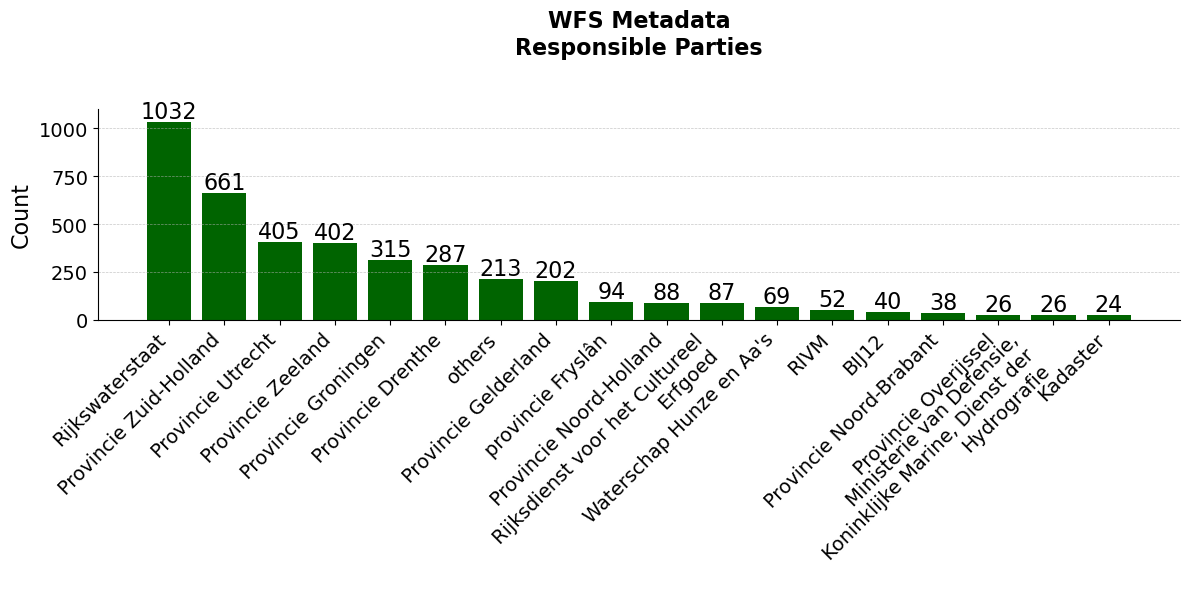

In [29]:
vc = df_wfs['md_contact_name'].value_counts()

# Step 2: Define threshold and separate common vs rare
threshold = 20
common = vc[vc > threshold]
rare = vc[vc <= threshold]

# Step 3: Create new Series with 'others'
grouped = common.copy()
grouped['others'] = rare.sum()

import textwrap
import matplotlib.pyplot as plt

# Sort and wrap long labels
sorted_grouped = grouped.sort_values(ascending=False)
wrapped_labels = [
    '\n'.join(textwrap.wrap(label, width=30))
    for label in sorted_grouped.index
]
valid_counts = sorted_grouped.values

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(wrapped_labels, valid_counts, color='darkgreen')

# Set y-axis limit
ax.set_ylim(0, 1100)

# Aesthetic improvements
ax.set_ylabel('Count', fontsize=16)
ax.set_title('WFS Metadata\nResponsible Parties', fontsize=16, pad=40, fontweight='bold')

# Rotate x-axis labels
ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=14)
ax.tick_params(axis='y', labelsize=14)

# Add grid and clean up plot
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 20,
            f'{int(height)}', ha='center', fontsize=16)

plt.tight_layout()
plt.show()


---

## 2. Spatial filter

**Loading data frames**:

In [31]:
df_wcs0 = pd.read_csv("checkpoint02_ngr_WCS_metadata.csv")
df_wcs1 = pd.read_csv("checkpoint03_sf1_ngr_WCS_metadata.csv")
df_wcs2 = pd.read_csv("checkpoint03_sf2_ngr_WCS_metadata.csv")

df_wfs0 = pd.read_csv("checkpoint02_ngr_WFS_metadata.csv")
df_wfs1 = pd.read_csv("checkpoint03_sf1_ngr_WFS_metadata.csv")
df_wfs2 = pd.read_csv("checkpoint03_sf2_ngr_WFS_metadata.csv")

In [32]:
import geopandas as gpd
from shapely.geometry import box
import ast

def transform_bbox_wgs84_to_28992(df, input_col, output_col):
    """
    Converts bounding box strings in WGS84 to bounding boxes in EPSG:28992.

    Parameters:
    - df: pandas DataFrame
    - input_col: name of the column containing bbox as strings (e.g. "('5.033', '52.251', '5.852', '53.082')")
    - output_col: name of the new column to store bbox tuples in EPSG:28992

    Returns:
    - DataFrame with a new column containing transformed bbox as (minx, miny, maxx, maxy) in EPSG:28992
    """
    transformed_bboxes = []

    for bbox_str in df[input_col]:
        try:
            # Parse the string to tuple of floats
            bbox_tuple = tuple(map(float, ast.literal_eval(bbox_str)))
            minx, miny, maxx, maxy = bbox_tuple

            # Create WGS84 geometry
            gdf = gpd.GeoDataFrame(
                geometry=[box(minx, miny, maxx, maxy)],
                crs="EPSG:4326"
            )

            # Transform to EPSG:28992
            gdf_28992 = gdf.to_crs(epsg=28992)
            transformed = gdf_28992.geometry.iloc[0].bounds  # (minx, miny, maxx, maxy)

            transformed_bboxes.append(transformed)
        except Exception as e:
            transformed_bboxes.append(None)

    df[output_col] = transformed_bboxes
    return df


In [33]:
df_wcs0_28992 = transform_bbox_wgs84_to_28992(df=df_wcs0, input_col="bounding_box", output_col="bbox_28992")
df_wcs1_28992 = transform_bbox_wgs84_to_28992(df=df_wcs1, input_col="bounding_box", output_col="bbox_28992")
df_wcs2_28992 = transform_bbox_wgs84_to_28992(df=df_wcs2, input_col="bounding_box", output_col="bbox_28992")

df_wfs0_28992 = transform_bbox_wgs84_to_28992(df=df_wfs0, input_col="bounding_box", output_col="bbox_28992")
df_wfs1_28992 = transform_bbox_wgs84_to_28992(df=df_wfs1, input_col="bounding_box", output_col="bbox_28992")
df_wfs2_28992 = transform_bbox_wgs84_to_28992(df=df_wfs2, input_col="bounding_box", output_col="bbox_28992")

**Loading outlines**

In [34]:
NLshp_path = os.path.join(outlines_path, "ne_10m_admin_0_countries/ne_10m_NL.shp")
VELshp_path = os.path.join(outlines_path, "nationaal_landschap/Veluwe_outline_simplified.shp")
WADshp_path = os.path.join(outlines_path, "PKB_gebied_derde_nota_waddenzee.gpkg")

NLgdf = gpd.read_file(NLshp_path)
VELgdf = gpd.read_file(VELshp_path)
WADgdf = gpd.read_file(WADshp_path)

# Filter Netherlands
netherlands4326 = NLgdf[NLgdf["NAME"] == "Netherlands"].to_crs(epsg=4326)
netherlands28992 = NLgdf[NLgdf["NAME"] == "Netherlands"].to_crs(epsg=28992)

veluwe4326 = VELgdf.to_crs(epsg=4326)
veluwe28992 = VELgdf.to_crs(epsg=28992)
veluwe28992 = veluwe28992.dissolve()

wadden4326 = WADgdf.to_crs(epsg=4326)
wadden28992 = WADgdf.to_crs(epsg=28992)

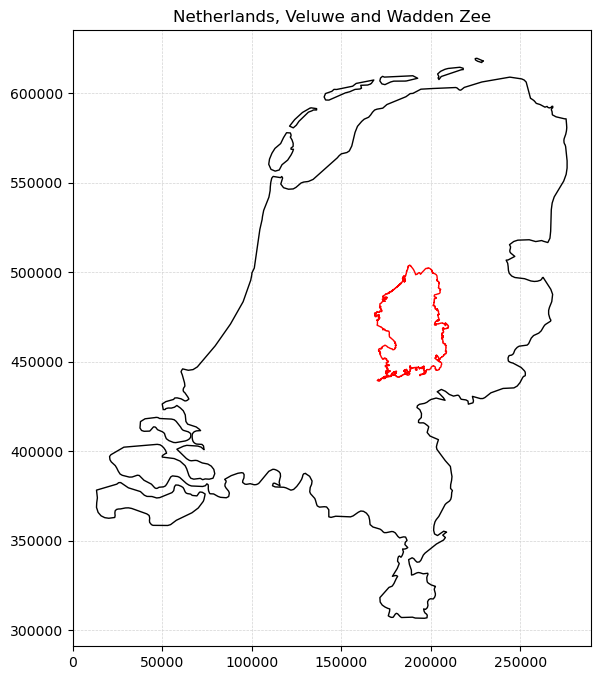

In [35]:
from shapely.geometry import box

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Netherlands border
netherlands28992.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot Veluwe border
veluwe28992.boundary.plot(ax=ax, color='red', linewidth=1)

# Optional: Add title or grid
ax.set_title("Netherlands, Veluwe and Wadden Zee")
ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5)

plt.show()

**Counts**

In [48]:
print("WCS original data:",len(df_wcs0_28992))
print("WCS spatial filter 1:",len(df_wcs1_28992))
print("WCS spatial filter 2:",len(df_wcs2_28992))
print("-------------------------")
print("WFS original data:",len(df_wfs0_28992))
print("WFS spatial filter 1:",len(df_wfs1_28992))
print("WFS spatial filter 2:",len(df_wfs2_28992))

WCS original data: 912
WCS spatial filter 1: 658
WCS spatial filter 2: 28
-------------------------
WFS original data: 4215
WFS spatial filter 1: 2001
WFS spatial filter 2: 1289


**Plotting bounding boxes**

In [40]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box

def plot_ogc_bboxes(df, title, netherlands_gdf, veluwe_gdf):
    """
    Plot bounding boxes from WFS metadata on top of Netherlands and Veluwe borders.

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'bbox_28992' column with bounding box tuples.
        title (str): Title for the plot.
        netherlands_gdf (GeoDataFrame): Netherlands boundary GeoDataFrame in EPSG:28992.
        veluwe_gdf (GeoDataFrame): Veluwe boundary GeoDataFrame in EPSG:28992.
    """
    # 1. Filter valid bounding boxes
    bbox_valid = df['bbox_28992'].dropna()

    # 2. Convert to GeoDataFrame
    gdf_bbox = gpd.GeoDataFrame(
        geometry=bbox_valid.apply(lambda tup: box(*tup)),
        crs="EPSG:28992"
    )

    # 3. Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # 4. Plot borders and bounding boxes
    netherlands_gdf.boundary.plot(ax=ax, color='black', linewidth=1, label="Netherlands")
    gdf_bbox.boundary.plot(ax=ax, color='blue', linewidth=0.4, alpha=0.6, label="WFS bboxes")
    veluwe_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label="Veluwe")

    # 5. Set axis bounds
    ax.set_xlim(-49621.01646005115, 331962.94916459604)
    ax.set_ylim(202177.01546319216, 693234.3298455146)

    # 6. Formatting
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
    ax.set_aspect('equal')
    ax.legend(loc="lower right")

    plt.show()


**WCS plots**

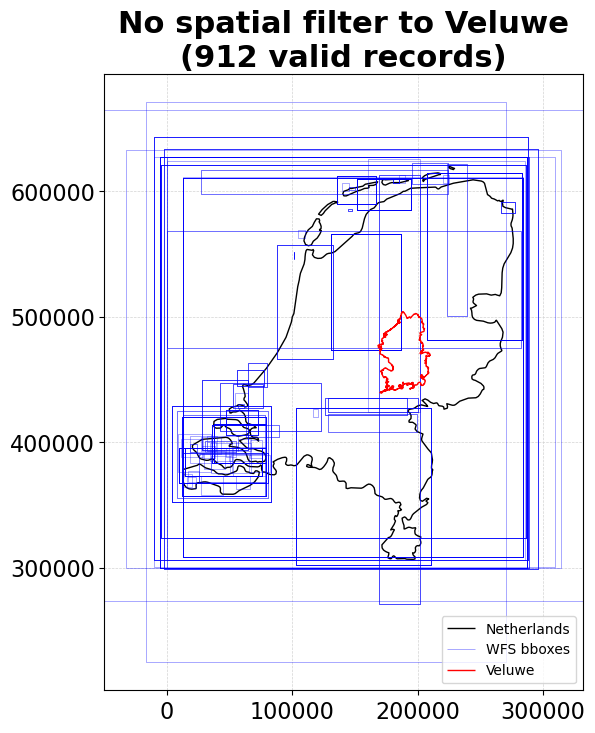

In [49]:
plot_ogc_bboxes(df_wcs0_28992,
                title="No spatial filter to Veluwe\n(912 valid records)",
                netherlands_gdf=netherlands28992,
                veluwe_gdf=veluwe28992)

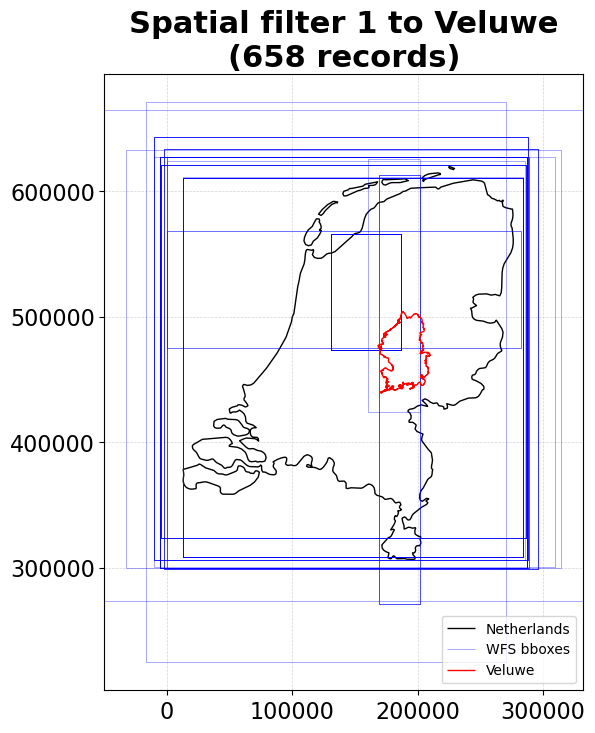

In [50]:
plot_ogc_bboxes(df_wcs1_28992,
                title="Spatial filter 1 to Veluwe\n(658 records)",
                netherlands_gdf=netherlands28992,
                veluwe_gdf=veluwe28992)

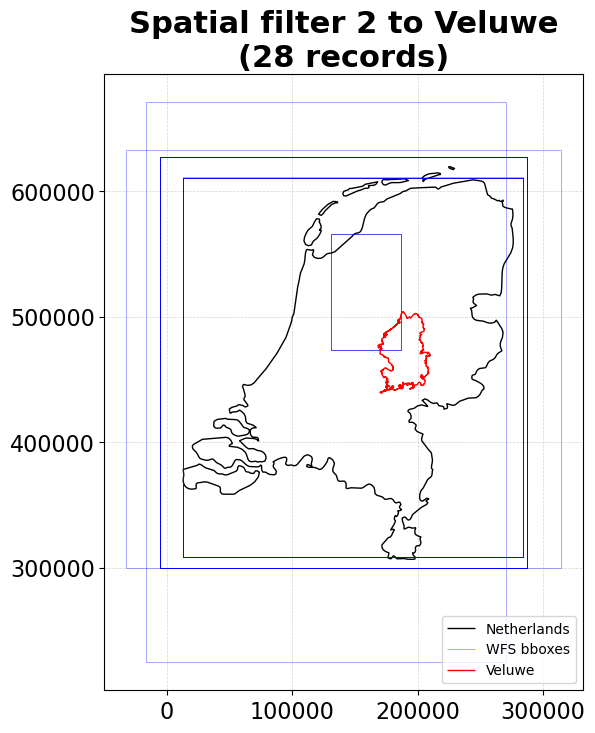

In [51]:
plot_ogc_bboxes(df_wcs2_28992,
                title="Spatial filter 2 to Veluwe\n(28 records)",
                netherlands_gdf=netherlands28992,
                veluwe_gdf=veluwe28992)

**WFS plots**

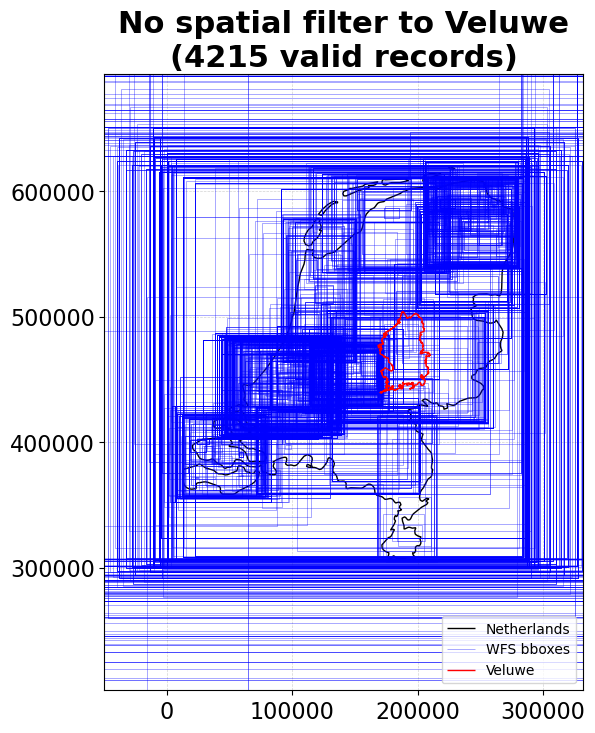

In [52]:
plot_ogc_bboxes(df_wfs0_28992,
                title="No spatial filter to Veluwe\n(4215 valid records)",
                netherlands_gdf=netherlands28992,
                veluwe_gdf=veluwe28992)

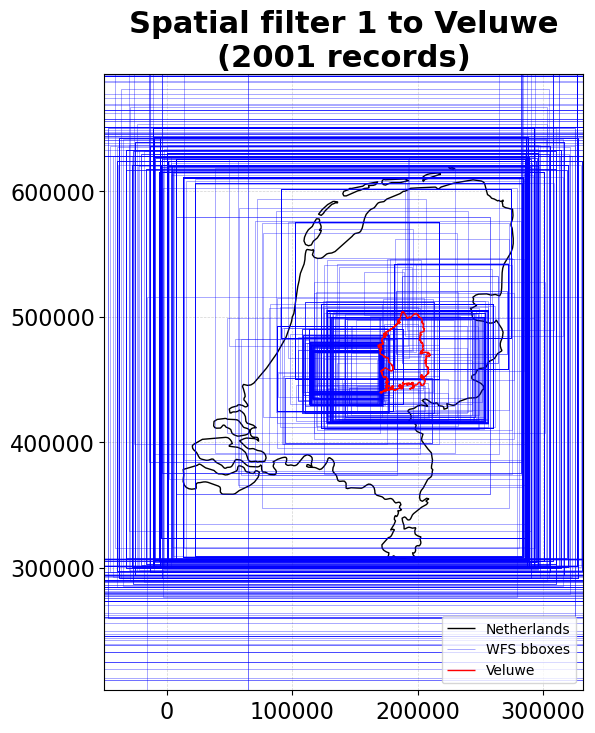

In [53]:
plot_ogc_bboxes(df_wfs1_28992,
                title="Spatial filter 1 to Veluwe\n(2001 records)",
                netherlands_gdf=netherlands28992,
                veluwe_gdf=veluwe28992)

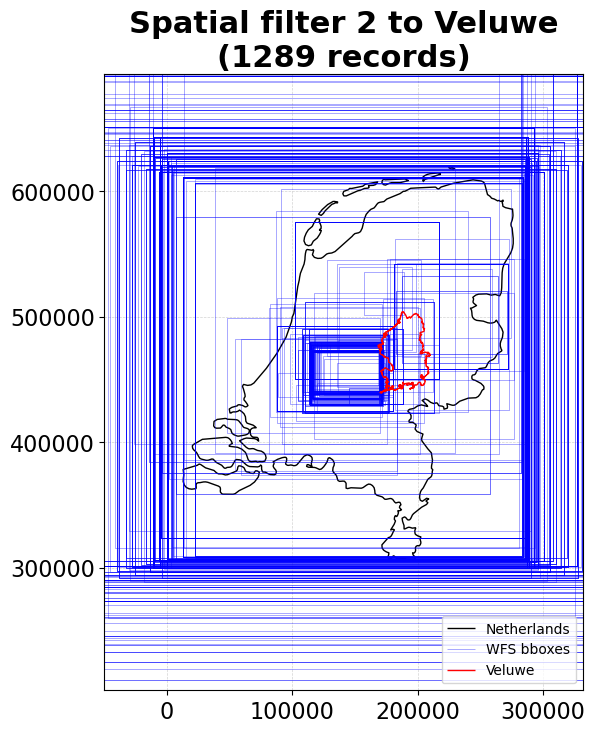

In [54]:
plot_ogc_bboxes(df_wfs2_28992,
                title="Spatial filter 2 to Veluwe\n(1289 records)",
                netherlands_gdf=netherlands28992,
                veluwe_gdf=veluwe28992)

---

## 3. Content filter

**Loading**

In [66]:
df_wcs_filter_s1 = pd.read_csv("checkpoint02_ngr_WCS_metadata.csv")
df_wcs_filter_s2 = pd.read_csv("checkpoint03_sf2_ngr_WCS_metadata.csv")
df_wcs_filter_s2c1 = pd.read_csv("checkpoint04_ngr_WCS_metadata.csv")

df_wfs_filter_s1 = pd.read_csv("checkpoint02_ngr_WFS_metadata.csv")
df_wfs_filter_s2 = pd.read_csv("checkpoint03_sf2_ngr_WFS_metadata.csv")
df_wfs_filter_s2c1 = pd.read_csv("checkpoint04_ngr_WFS_metadata.csv")

**Counts**

In [67]:
print("WCS spatial filter 1",len(df_wcs_filter_s1))
print("WCS spatial filter 2:",len(df_wcs_filter_s2))
print("WCS content filter:",len(df_wcs_filter_s2c1))
print("-------------------------")
print("WFS spatial filter 1:",len(df_wfs_filter_s1))
print("WFS spatial filter 2:",len(df_wfs_filter_s2))
print("WFS content filter:",len(df_wfs_filter_s2c1))

WCS spatial filter 1 912
WCS spatial filter 2: 28
WCS content filter: 11
-------------------------
WFS spatial filter 1: 4215
WFS spatial filter 2: 1289
WFS content filter: 502


**Plot**

In [68]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_keywords(
    df: pd.DataFrame,
    column: str = "keywords",
    top_n: int = 20,
    figsize: tuple = (4, 6),
    bar_color: str = "lightgreen",
    title: str = "WCS keywords",
    missing_label: str = "<missing>",
):
    """
    Extract the *top_n* most-common semicolon-delimited keywords from *df[column]*,
    **including missing values**, plot them, and return both the tidy frequency
    table and the matplotlib Axes object.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing a column with semicolon-separated keyword strings.
    column : str, default "keywords"
        Name of the column holding the keywords.
    top_n : int, default 20
        How many of the most-frequent keywords to show.
    figsize : tuple, default (4, 6)
        Size of the figure.
    bar_color : str, default "lightgreen"
        Color of the horizontal bars.
    title : str, default "WCS keywords"
        Plot title.
    missing_label : str, default "<missing>"
        Label used to represent missing keywords.

    Returns
    -------
    df_top : pd.DataFrame
        Two-column DataFrame with keywords and their counts, ordered by *count*
        descending (but plotted ascending for horizontal bars).
    ax : matplotlib.axes.Axes
        The Axes on which the chart was drawn.
    """
    # --- 1. Tokenize non-missing entries -----------------------------------
    non_null = (
        df[column]
        .dropna()
        .str.split(";")
        .explode()
        .str.strip()
    )

    # --- 2. Count everything ----------------------------------------------
    keyword_counts = Counter(non_null)

    missing_count = df[column].isna().sum()
    if missing_count:
        keyword_counts[missing_label] = missing_count

    top_keywords = keyword_counts.most_common(top_n)

    df_top = (
        pd.DataFrame(top_keywords, columns=["keyword", "count"])
        .sort_values("count", ascending=True)   # ascending for barh
        .reset_index(drop=True)
    )
    df_top.index = df_top["keyword"]

    # --- 3. Plot -----------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    df_top["count"].plot(kind="barh", ax=ax, color=bar_color)

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Count", fontsize=10)
    ax.set_ylabel("")
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.spines[["top", "right"]].set_visible(False)

    for i, v in enumerate(df_top["count"].values):
        ax.text(v + 0.5, i, str(v), va="center", fontsize=10)

    plt.tight_layout()

    return df_top, ax


**WCS**

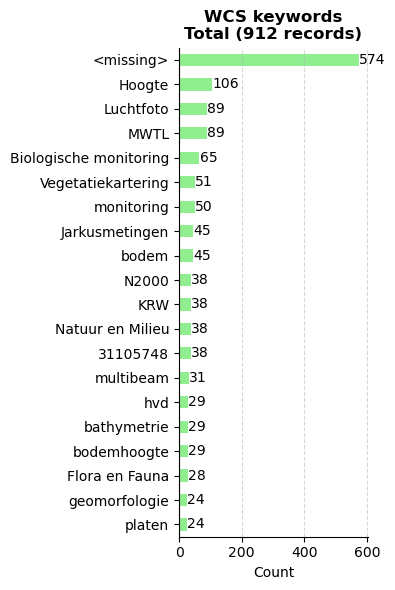

In [69]:
df_top, ax = plot_top_keywords(df_wcs_filter_s1, title = "WCS keywords\nTotal (912 records)")
plt.show()  

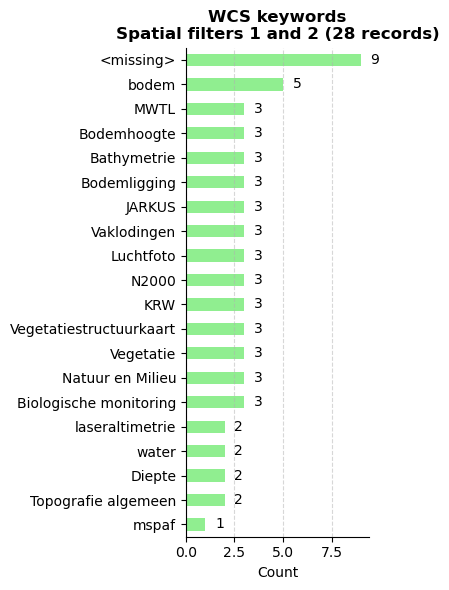

In [70]:
df_top, ax = plot_top_keywords(df_wcs_filter_s2, title = "WCS keywords\nSpatial filters 1 and 2 (28 records)")
plt.show()  

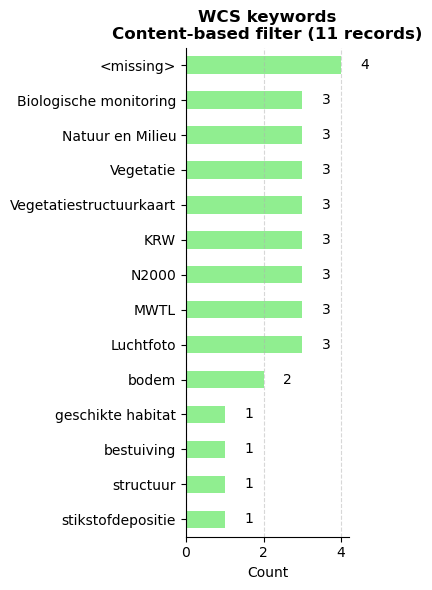

In [71]:
df_top, ax = plot_top_keywords(df_wcs_filter_s2c1, title = "WCS keywords\nContent-based filter (11 records)")
plt.show()  

**WFS**

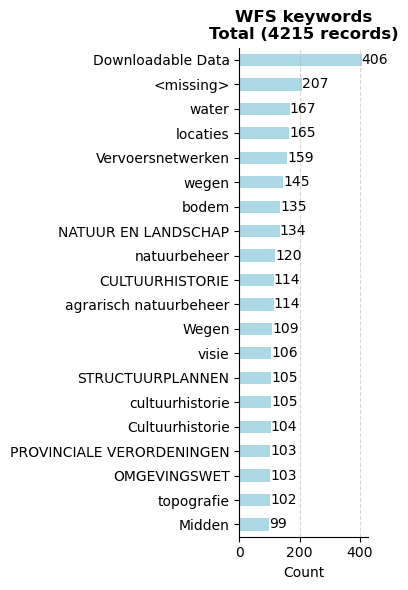

In [72]:
df_top, ax = plot_top_keywords(df_wfs_filter_s1, title = "WFS keywords\nTotal (4215 records)", bar_color = "lightblue")
plt.show()  

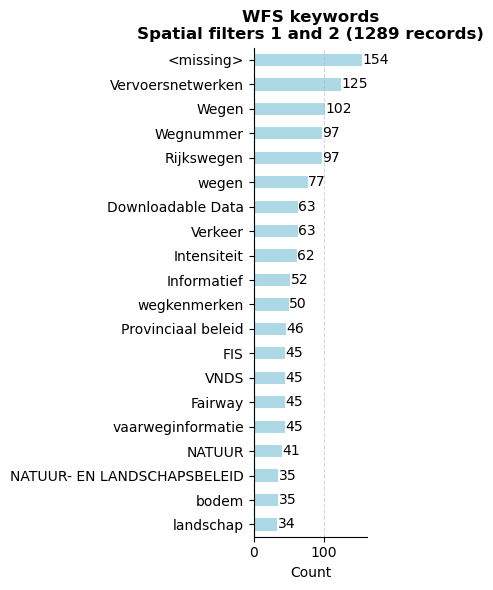

In [73]:
df_top, ax = plot_top_keywords(df_wfs_filter_s2, title = "WFS keywords\nSpatial filters 1 and 2 (1289 records)", bar_color = "lightblue")
plt.show() 

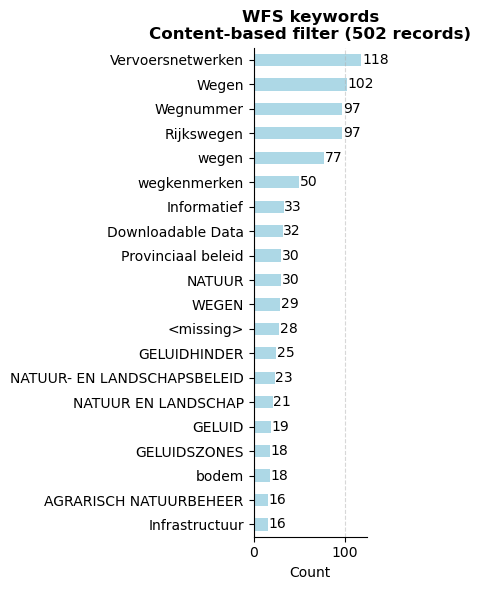

In [74]:
df_top, ax = plot_top_keywords(df_wfs_filter_s2c1, title = "WFS keywords\nContent-based filter (502 records)", bar_color = "lightblue")
plt.show()  

---

---